# Plotting glider tracks

_Written by Lori Garzio, June 14, 2023_

[Rutgers Center for Ocean Observing Leadership](https://rucool.marine.rutgers.edu/) (RUCOOL)

This notebook shows you how to plot glider tracks on a map along with bathymetry. The glider track will be colored by time to give you a sense of where the glider was at what time. In this example we will be using data manually downloaded from the [IOOS Glider DAC ERDDAP server](https://gliders.ioos.us/erddap/index.html). See the download_data_dac notebook for detailed instructions.

In [1]:
# import required packages
import os
import datetime as dt
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean as cmo

Specify the file paths for the dataset you would like to plot and the bathymetry data file. Load the datasets using xarray.

In [2]:
f = '/Users/garzio/Documents/rucool/gliderdata/ru30-20210716T1804-delayed.nc'
bathymetry = '/Users/garzio/Documents/rucool/bathymetry/GEBCO_2014_2D_-100.0_0.0_-10.0_50.0.nc'

ds = xr.open_dataset(f)
bathy_ds = xr.open_dataset(bathymetry)

Specify where you want the plot to be saved on your local machine.

In [3]:
save_dir = '/Users/garzio/Documents/rucool/gliderplots'

Look at the dataset for variables, time range, etc.

In [4]:
ds

<xarray.Dataset>
Dimensions:                         (row: 1894148)
Dimensions without coordinates: row
Data variables: (12/28)
    time                            (row) datetime64[ns] ...
    latitude                        (row) float64 ...
    longitude                       (row) float64 ...
    depth                           (row) float32 ...
    aragonite_saturation_state      (row) float32 ...
    chlorophyll_a                   (row) float32 ...
    ...                              ...
    salinity_interpolated           (row) float32 ...
    salinity_lag_shifted            (row) float32 ...
    temperature                     (row) float32 ...
    temperature_interpolated        (row) float32 ...
    temperature_lag_shifted         (row) float32 ...
    total_alkalinity                (row) float32 ...
Attributes: (12/59)
    acknowledgment:                This deployment supported by the NOAA Ocea...
    cdm_data_type:                 TrajectoryProfile
    cdm_profile_variables:         time_uv,lat_uv,lon_uv,u,v,profile_id,time,...
    cdm_trajectory_variables:      trajectory,wmo_id
    comment:                       Glider operated by the Rutgers University ...
    contributor_name:              Grace Saba, Theodore Thompson, Dave Aragon...
    ...                            ...
    subsetVariables:               wmo_id,trajectory,profile_id,time,latitude...
    summary:                       This project is conducting seasonal deploy...
    time_coverage_end:             2021-08-20T16:56:16.31Z
    time_coverage_start:           2021-07-16T18:06:48.11Z
    title:                         ru30-20210716T1804-delayed
    Westernmost_Easting:           -74.59385

Swap the dimensions to 'time'. This makes it easier to subset the dataset by time if you want to do that for any reason. 

In [5]:
ds = ds.swap_dims({'row': 'time'})

Get the deployment name from the global attributes and find the minimum and maximum timestamps - I usually put these in the title of the plot.

In [6]:
deployment_id = ds.title
t0 = pd.to_datetime(np.nanmin(ds.time)).strftime('%Y-%m-%dT%H:%M')
tf = pd.to_datetime(np.nanmax(ds.time)).strftime('%Y-%m-%dT%H:%M')
title = f'{deployment_id}\n{t0} to {tf}'
print(title)

ru30-20210716T1804-delayed
2021-07-16T18:06 to 2021-08-20T16:56


Define the bounding box for the plotting function by grabbing the latitude and longitude from the glider and add a buffer. This avoids having to manually set the extent for the plotting function.

In [7]:
extent = [np.nanmin(ds.longitude.values) - 2, np.nanmax(ds.longitude.values) + 2,
          np.nanmin(ds.latitude.values) - 1.5, np.nanmax(ds.latitude.values) + 1.5]
print(extent)

[-76.59385, -71.08392, 36.64329, 40.93324]


Subset the bathymetry dataset using your plotting limits so you aren't trying to plot a large amount of data.

In [8]:
bathy_ds = bathy_ds.sel(lon=slice(extent[0], extent[1]),
                        lat=slice(extent[2], extent[3]))

bathy_ds

<xarray.Dataset>
Dimensions:    (lat: 515, lon: 661)
Coordinates:
  * lat        (lat) float64 36.65 36.65 36.66 36.67 ... 40.9 40.91 40.92 40.93
  * lon        (lon) float64 -76.59 -76.58 -76.57 -76.56 ... -71.1 -71.1 -71.09
Data variables:
    elevation  (lat, lon) float64 ...
Attributes:
    Conventions:  CF-1.0
    title:        The GEBCO_2014 Grid - a continuous terrain model for oceans...
    institution:  On behalf of the General Bathymetric Chart of the Oceans (G...
    source:       The bathymetric portion of the GEBCO_2014 Grid was largely ...
    history:      This is version 20150318 of the data set. Information on th...
    references:   Information on the data set is available from the GEBCO pro...
    comment:      The data in the GEBCO_2014 Grid should not be used for navi...
    node_offset:  1
    History:      Translated to CF-1.0 Conventions by Netcdf-Java CDM (Netcdf...

The function below generates the map. First, set up the plot and adjust the side margin so we can add the timestamps to the colorbar. Then add the bathymetry data as your first layer in the plot. Here we use the [cmocean colormap](https://matplotlib.org/cmocean/) "topo" for the topography/bathymetry. We will also add a dotted line to highlight more of the features on the shelf, add more features like state lines and rivers, add gridlines, and add labels for the coordinates. Then plot all of the glider coorinates in black as a background color (just to distinguish them from the bathymetry color), and add the coordinates with colors according to time. Finally add a colorbar showing which colors coordinate with which times and save the plot to your local machine. This will take a few seconds because we're plotting a lot of data.

In [9]:
def glider_map(dataset, bathymetry_ds, plt_extent, plt_title, save_name):
    fig, ax = plt.subplots(figsize=(11, 8), subplot_kw=dict(projection=ccrs.Mercator()))
    plt.subplots_adjust(right=0.82)  # adjust margins for colorbar

    # add bathymetry/topography as a colormap
    levels = np.arange(-5000, 5100, 50)
    bath_lat = bathymetry_ds.variables['lat'][:]
    bath_lon = bathymetry_ds.variables['lon'][:]
    bath_elev = bathymetry_ds.variables['elevation'][:]
    plt.contourf(bath_lon, bath_lat, bath_elev, levels, cmap=cmo.cm.topo, transform=ccrs.PlateCarree())

    # add dotted lines
    levels = np.arange(-100, 0, 50)
    CS = plt.contour(bath_lon, bath_lat, bath_elev, levels, linewidths=.75, alpha=.5, colors='k',
                     transform=ccrs.PlateCarree())
    ax.clabel(CS, [-100], inline=True, fontsize=7, fmt='%d')  # add a label at the 100m isobath

    # add additional features
    state_lines = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale='10m',
            facecolor='none')

    ax.add_feature(cfeature.RIVERS)
    ax.add_feature(cfeature.LAKES)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(state_lines)

    # specify the limits of the map
    ax.set_extent(plt_extent)

    # Gridlines and grid labels
    gl = ax.gridlines(
        draw_labels=True,
        linewidth=.5,
        color='black',
        alpha=0.25,
        linestyle='--'
    )

    # latitude and longitude labels
    gl.top_labels = gl.right_labels = False
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    # get the glider coordinates and add those as points on the map
    lon = dataset.longitude.values
    lat = dataset.latitude.values

    ax.scatter(lon, lat, color='k', marker='.', s=60, transform=ccrs.PlateCarree(), zorder=10)
    sct = ax.scatter(lon, lat, c=dataset.time.values, marker='.', s=15, cmap='rainbow', 
                     transform=ccrs.PlateCarree(), zorder=10)

    # add the plot title
    plt.title(plt_title, fontsize=12)

    # Set colorbar height equal to plot height
    divider = make_axes_locatable(ax)
    cax = divider.new_horizontal(size='5%', pad=0.05, axes_class=plt.Axes)
    fig.add_axes(cax)

    # generate colorbar
    cbar = plt.colorbar(sct, cax=cax)
    cbar.ax.set_yticklabels(pd.to_datetime(cbar.ax.get_yticks()).strftime(date_format='%Y-%m-%d'))

    # save the plot to your local machine
    plt.savefig(save_name, dpi=300)

Now we can run the function with our inputs for this dataset - this generates a map of the entire glider deployment.

/var/folders/_h/5x4zz6xx04s4g8bp7wf8ftjm0000gn/T/ipykernel_32067/1509479754.py:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(pd.to_datetime(cbar.ax.get_yticks()).strftime(date_format='%Y-%m-%d'))


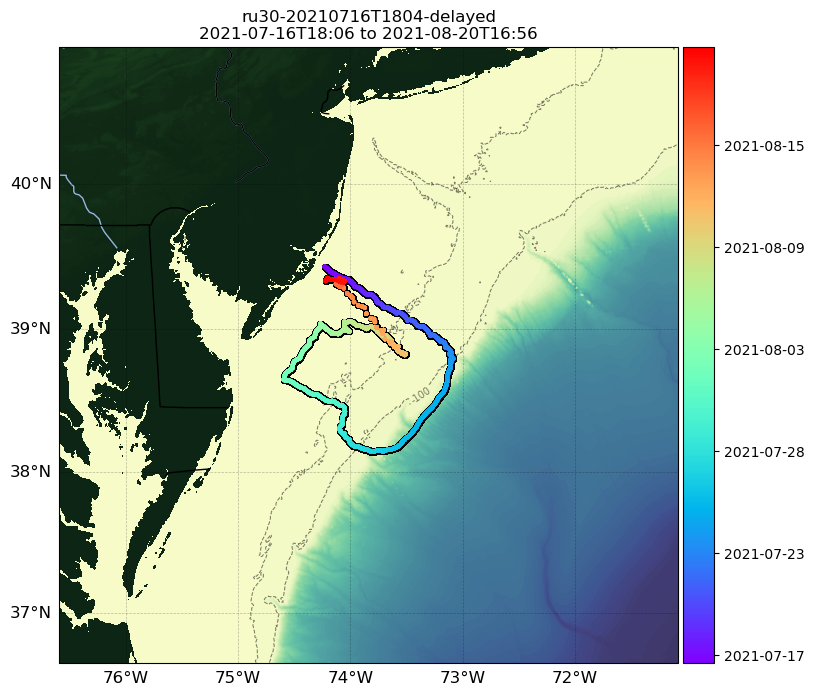

In [10]:
fname = f'{deployment_id}_glider-track.png'
sname = os.path.join(save_dir, fname)

# run the function
glider_map(ds, bathy_ds, extent, title, sname)

Print where you saved the plot so you can find it (yes we've all had that problem!) and close the plot.

In [11]:
plt.close()
print(f'File saved to: {sname}')

File saved to: /Users/garzio/Documents/rucool/gliderplots/ru30-20210716T1804-delayed_glider-track.png


Since we switched the file dimension to be "time", we can easily select a subset of the data if we just want to plot one section of the glider deployment. Since we're interested in cross-shelf transects, let's try to select just that first transect that traverses directly offshore.

In [12]:
time0 = dt.datetime(2021, 7, 16, 18, 0)
time1 = dt.datetime(2021, 7, 24, 0, 0)
ds_sub = ds.sel(time=slice(time0, time1))

# make a new title with the subset dates
title_sub = f'{deployment_id}\n{time0.strftime("%Y-%m-%dT%H:%M")} to {time1.strftime("%Y-%m-%dT%H:%M")}'
print(title)

ru30-20210716T1804-delayed
2021-07-16T18:06 to 2021-08-20T16:56


Now that we've subset this dataset, we can generate the same map but just the first cross-shelf transect.

/var/folders/_h/5x4zz6xx04s4g8bp7wf8ftjm0000gn/T/ipykernel_32067/1509479754.py:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(pd.to_datetime(cbar.ax.get_yticks()).strftime(date_format='%Y-%m-%d'))


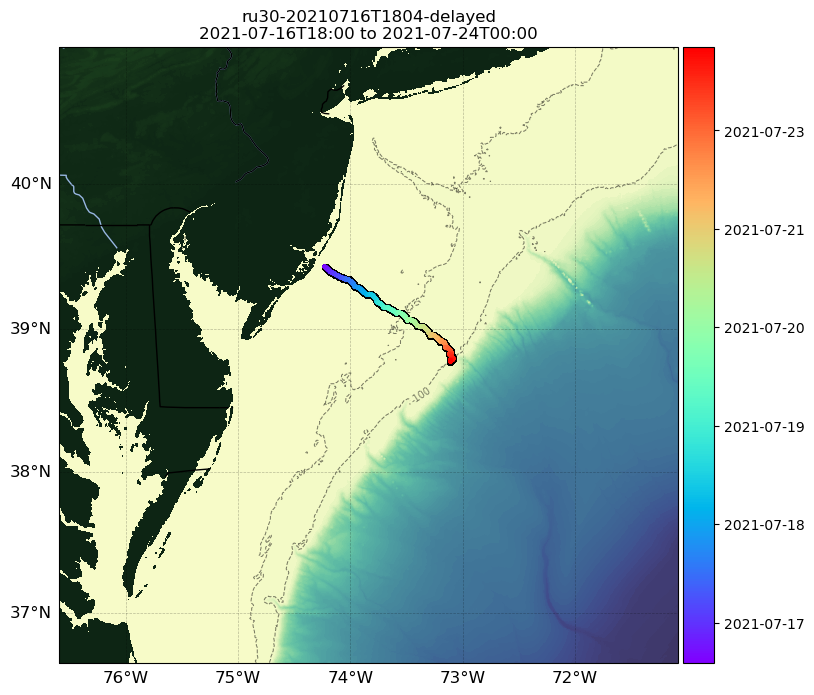

In [13]:
fname_sub = f'{deployment_id}_glider-track-transect.png'
sname_sub = os.path.join(save_dir, fname_sub)

# run the function with new inputs
glider_map(ds_sub, bathy_ds, extent, title_sub, sname_sub)

In [14]:
plt.close()
print(f'File saved to: {sname_sub}')

File saved to: /Users/garzio/Documents/rucool/gliderplots/ru30-20210716T1804-delayed_glider-track-transect.png
